In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import LeaveOneOut, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import (
    GammaRegressor,
    TweedieRegressor,
    PassiveAggressiveRegressor,
    BayesianRidge,
    ARDRegression,
    RidgeCV,
    Ridge,
    LinearRegression,
)
from sklearn.preprocessing import (
    PolynomialFeatures,
    PowerTransformer,
    QuantileTransformer,
)
from sklearn.pipeline import Pipeline
from scipy.optimize import minimize
from pathlib import Path

INPUT_PATH = Path("/mnt/storage_dimm2/kaggle_data/commonlitreadabilityprize")
OUTPUT_PATH = Path("/mnt/storage_dimm2/kaggle_output/commonlitreadabilityprize")

torch.manual_seed(48)
np.random.seed(48)

FOLDS = 10

In [2]:
model_folders = [
    "20210614-203831",
    "20210615-094729",
    "20210616-003038",
    "20210616-041221",
    "20210616-132341",
    "20210617-135233",
    "20210618-183719",
    "20210618-223208",
    "20210619-004022",
    "20210619-035747",
    "20210619-064351",
    "20210619-093050",
    "20210623-201514",
    "20210623-232231",
    "20210624-012102",
    "20210624-015812",
    "20210624-101855",
    "20210624-044356",
    "20210624-113506",
    "20210624-150250",
    "20210627-105133",
    "20210627-152616",
    "20210627-105144",
    "20210627-151904",
    "20210628-045559",
    "20210628-085322",
    "20210627-213946",
    "20210628-031447",
    "20210628-114738",
    "20210628-145921",
    "20210628-212819",
    "20210629-012726",
    "20210629-035901",
    "20210629-163239",
    "20210705-162253",
    "20210710-124531",
    "20210710-173710",
]

In [3]:
def build_oof_df(folders):
    dataset_paths = [OUTPUT_PATH / f for f in folders]
    mpaths, oof_paths = [], []
    for p in dataset_paths:
        mpaths.append(sorted(list(p.glob(f"*/*/*.ckpt"))))
        oof_paths.extend(sorted(list(p.glob(f"*.csv"))))

    oofs = pd.read_csv(
        INPUT_PATH / "train.csv", usecols=["id", "target", "standard_error"]
    ).sort_values(by="id")
    for i, p in enumerate(oof_paths):
        x = pd.read_csv(p).sort_values(by="id")
        oofs[p.parent.name] = x["prediction"].values

    return oofs.reset_index(drop=True)


def create_folds(data, n_splits, random_state=None):
    # we create a new column called fold and fill it with -1
    data["fold"] = -1

    # the next step is to randomize the rows of the data
    data = data.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # calculate number of bins by Sturge's rule
    # I take the floor of the value, you can also
    # just round it
    num_bins = int(np.floor(1 + np.log2(len(data))))

    # bin targets
    data.loc[:, "bins"] = pd.cut(data["target"], bins=num_bins, labels=False)

    # initiate the kfold class from model_selection module
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # fill the new kfold column
    # note that, instead of targets, we use bins!
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
        data.loc[v_, "fold"] = f

    # drop the bins column
    data = data.drop("bins", axis=1)

    # return dataframe with folds
    return data

In [4]:
oofs = build_oof_df(model_folders)
oofs = create_folds(oofs, FOLDS, 48)

train = pd.read_csv(INPUT_PATH / "train.csv").set_index("id")

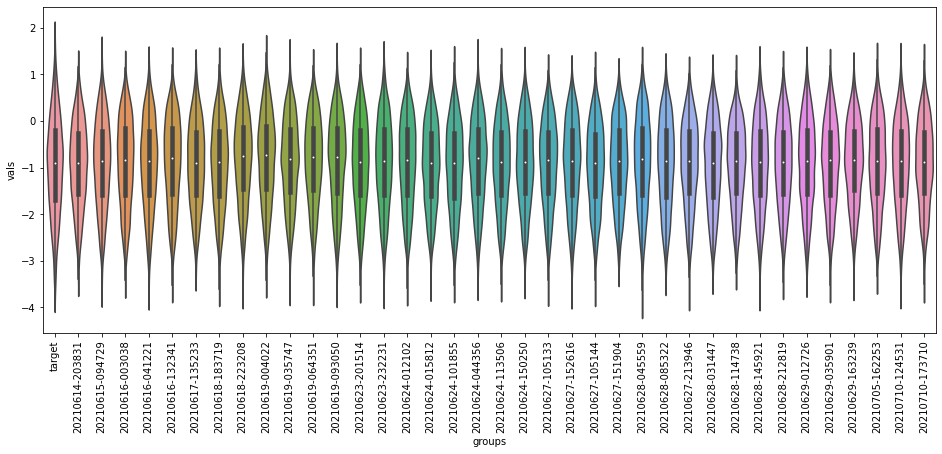

In [5]:
df = oofs[["target"] + model_folders].melt(var_name='groups', value_name='vals')

plt.figure(figsize=(16, 6))
sns.violinplot(x="groups", y="vals", data=df)
plt.xticks(rotation=90);

In [6]:
oofs.describe()

,target,standard_error,20210614-203831,20210615-094729,20210616-003038,20210616-041221,20210616-132341,20210617-135233,20210618-183719,20210618-223208,...,20210628-114738,20210628-145921,20210628-212819,20210629-012726,20210629-035901,20210629-163239,20210705-162253,20210710-124531,20210710-173710,fold
count,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,...,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000,2834.000000
mean,-0.959319,0.491435,-0.939186,-0.910382,-0.896866,-0.916181,-0.879872,-0.922074,-0.931533,-0.817811,...,-0.932925,-0.930065,-0.921654,-0.909139,-0.914359,-0.877770,-0.897710,-0.921113,-0.911464,4.495766
std,1.033579,0.034818,0.889185,0.927470,0.931740,0.932122,0.918958,0.888574,0.900377,0.909995,...,0.850895,0.924109,0.896970,0.931322,0.900828,0.850334,0.906948,0.918001,0.882588,2.873277
min,-3.676268,0.000000,-3.392829,-3.607502,-3.413040,-3.665817,-3.516083,-3.274489,-3.604712,-3.650088,...,-3.267392,-3.685292,-3.456788,-3.393454,-3.523415,-3.496688,-3.336777,-3.644846,-3.534374,0.000000
25%,-1.690320,0.468543,-1.570393,-1.581456,-1.591370,-1.584849,-1.560173,-1.590762,-1.601161,-1.458945,...,-1.540046,-1.599030,-1.576585,-1.568294,-1.582206,-1.479983,-1.552959,-1.594397,-1.544298,2.000000
50%,-0.912190,0.484721,-0.891787,-0.853657,-0.828833,-0.858165,-0.802899,-0.895744,-0.875757,-0.742822,...,-0.859889,-0.875647,-0.875814,-0.851253,-0.840314,-0.838576,-0.868300,-0.851400,-0.875494,4.000000
75%,-0.202540,0.506268,-0.258008,-0.206128,-0.145561,-0.206036,-0.156017,-0.230764,-0.225005,-0.121189,...,-0.259794,-0.217068,-0.236390,-0.194419,-0.228858,-0.220815,-0.180298,-0.212440,-0.234612,7.000000
max,1.711390,0.649671,1.150385,1.432130,1.127938,1.218783,1.204537,1.174591,1.208332,1.296482,...,1.070839,1.229287,1.137235,1.214720,1.178088,1.126063,1.308697,1.300148,1.293153,9.000000


<AxesSubplot:>

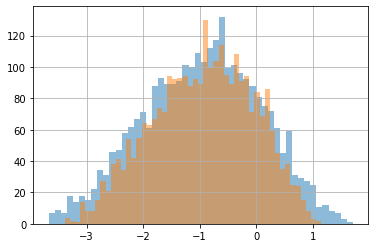

In [7]:
idx = 0

oofs["target"].hist(bins=50, alpha=0.5)
oofs[model_folders[idx]].hist(bins=50, alpha=0.5)

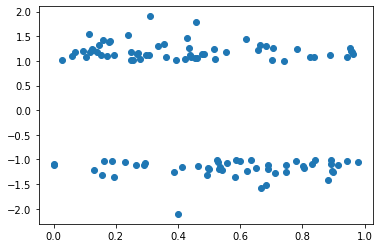

In [8]:
percentile = oofs[model_folders[idx]].rank(pct=True)
error = oofs[model_folders[idx]] - oofs["target"]

# Error as a function of percentile
plt.scatter(percentile[abs(error) > 1], error[abs(error) > 1]);

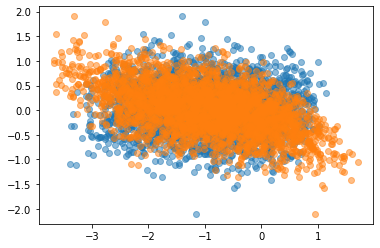

In [9]:
# Error as a function of prediction
plt.scatter(oofs[model_folders[idx]].values, error, alpha=0.5);
plt.scatter(oofs["target"].values, error, alpha=0.5);

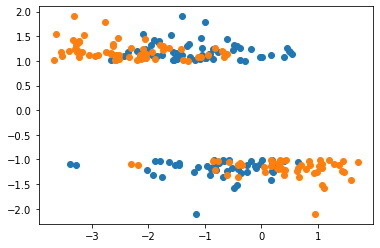

In [10]:
# Error as a function of prediction
plt.scatter(oofs[model_folders[idx]].values[abs(error) > 1], error[abs(error) > 1]);
plt.scatter(oofs["target"].values[abs(error) > 1], error[abs(error) > 1]);

In [11]:
# IDEA: Use std dev, min, max as a feature
oofs["std_dev"] = oofs[model_folders].std(1)
oofs["mean"] = oofs[model_folders].mean(1)
oofs["min"] = oofs[model_folders].min(1)
oofs["max"] = oofs[model_folders].max(1)
oofs["range"] = oofs[model_folders].max(1) - oofs[model_folders].min(1)

stat_feats = ["std_dev", "min", "max", "range"]

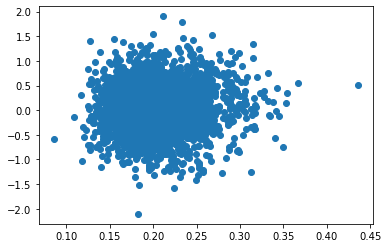

In [12]:
plt.scatter(oofs["std_dev"], error);

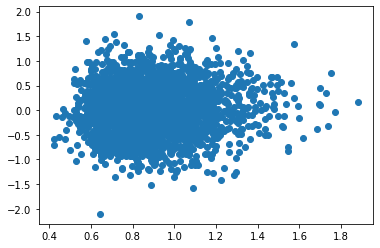

In [13]:
plt.scatter(oofs["range"], error);

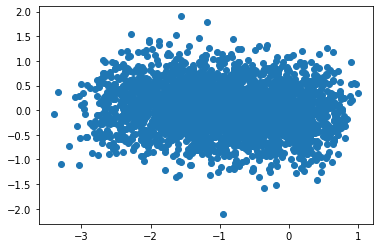

In [14]:
plt.scatter(oofs["mean"], error);

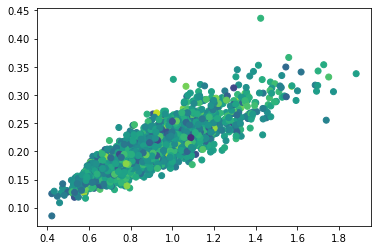

In [15]:
plt.scatter(oofs["range"], oofs["std_dev"], c=error);

In [16]:
np.sqrt(mean_squared_error(oofs[model_folders[idx]], oofs["target"])), r2_score(oofs[model_folders[idx]], oofs["target"])

(0.4840046293967861, 0.7036066334337061)

In [17]:
train.loc[oofs.iloc[np.argmax(error)]["id"], "excerpt"]

'While I was hailing the brig, I spied a tract of water lying between us, where no great waves came, but which yet boiled white all over and bristled in the moon with rings and bubbles. Sometimes the whole tract swung to one side, like the tail of a live serpent; sometimes, for a glimpse, it would all disappear and then boil up again. What it was I had no guess, which for the time increased my fear of it; but I now know it must have been the roost or tide-race, which had carried me away so fast and tumbled me about so cruelly, and at last, as if tired of that play, had flung out me and the spare yard upon its landward margin.\nI now lay quite becalmed, and began to feel that a man can die of cold as well as of drowning. The shores of Earraid were close in; I could see in the moonlight the dots of heather and the sparkling of the mica in the rocks.'

In [18]:
def postprocess(x, lower_thresh=0.1, upper_thresh=0.9, lower_multiplier=1.10, upper_multiplier=1.10):
    x = x.copy()
    lower_p = np.percentile(x, 100 * lower_thresh)
    upper_p = np.percentile(x, 100 * upper_thresh)
    x[x < lower_p] *= lower_multiplier
    x[x > upper_p] *= upper_multiplier
    return x


def obj_func(args, df, model):
    lower_thresh, upper_thresh, lower_multiplier, upper_multiplier = args
    x = postprocess(df[model], lower_thresh, upper_thresh, lower_multiplier, upper_multiplier)
    return np.sqrt(mean_squared_error(x, df["target"]))


def get_pp_params(df, model, verbose=True):
    before = np.sqrt(mean_squared_error(df[model], df["target"]))
    res = minimize(obj_func, [0.1, 0.9, 1.1, 1.1], args=(df, model,))
    if verbose:
        print(f"{before:0.5f} -> {res.fun:0.5f}")
    return res.x

oofs_pp = oofs.copy()
for m in model_folders:
    lower_thresh, upper_thresh, lower_multiplier, upper_multiplier = get_pp_params(oofs, m)
    oofs_pp[m] = postprocess(oofs[m], lower_thresh, upper_thresh, lower_multiplier, upper_multiplier)

0.48400 -> 0.48374
0.48619 -> 0.48529
0.50185 -> 0.50089
0.48270 -> 0.48129
0.50565 -> 0.50490
0.49567 -> 0.49485
0.52426 -> 0.52368
0.53449 -> 0.53104
0.55666 -> 0.54805
0.54313 -> 0.54150
0.52690 -> 0.52565
0.52331 -> 0.52162
0.47401 -> 0.47372
0.47171 -> 0.47043
0.50280 -> 0.50231
0.54510 -> 0.54481
0.50641 -> 0.50636
0.50901 -> 0.50818
0.49379 -> 0.49368
0.49110 -> 0.49036
0.49909 -> 0.49887
0.50915 -> 0.50867
0.49083 -> 0.49076
0.50323 -> 0.50247
0.48958 -> 0.48736
0.49418 -> 0.49351
0.52333 -> 0.52280
0.50882 -> 0.50869
0.52573 -> 0.52548
0.47120 -> 0.47058
0.47524 -> 0.47496
0.51401 -> 0.51199
0.50556 -> 0.50476
0.53018 -> 0.52852
0.51403 -> 0.51350
0.51010 -> 0.50901
0.53564 -> 0.53467


In [19]:
def rescale(x, scale=1.033579, loc=-0.959319):
    x_std = (x - x.mean()) / x.std()
    return x_std * scale + loc


def obj_func(args, df, model):
    scale, loc = args
    x = rescale(df[model], scale, loc)
    return np.sqrt(mean_squared_error(x, df["target"]))


def get_scale_params(df, model, verbose=True):
    before = np.sqrt(mean_squared_error(oofs[model], oofs["target"]))
    res = minimize(obj_func, [1.033579, -0.959319], args=(df, model,))
    if verbose:
        print(f"{before:0.5f} -> {res.fun:0.5f}")
    return res.x
    
    
oofs_rescaled = oofs.copy()
for m in model_folders:
    scale, loc = get_scale_params(oofs, m)
    oofs_rescaled[m] = rescale(oofs[m], scale, loc)

0.48400 -> 0.48296
0.48619 -> 0.48351
0.50185 -> 0.49729
0.48270 -> 0.48046
0.50565 -> 0.49918
0.49567 -> 0.49389
0.52426 -> 0.52345
0.53449 -> 0.51523
0.55666 -> 0.53210
0.54313 -> 0.53530
0.52690 -> 0.51386
0.52331 -> 0.51435
0.47401 -> 0.47223
0.47171 -> 0.46782
0.50280 -> 0.49955
0.54510 -> 0.54493
0.50641 -> 0.50633
0.50901 -> 0.50188
0.49379 -> 0.49282
0.49110 -> 0.48800
0.49909 -> 0.49665
0.50915 -> 0.50749
0.49083 -> 0.48980
0.50323 -> 0.49841
0.48958 -> 0.48012
0.49418 -> 0.49245
0.52333 -> 0.52161
0.50882 -> 0.50868
0.52573 -> 0.52352
0.47120 -> 0.47027
0.47524 -> 0.47324
0.51401 -> 0.51051
0.50556 -> 0.50355
0.53018 -> 0.52222
0.51403 -> 0.51026
0.51010 -> 0.50834
0.53564 -> 0.53349


# Linear baseline

In [20]:
fold_scores = []

for fold in range(FOLDS):
    trn_df = oofs.query(f"fold != {fold}").copy()
    val_df = oofs.query(f"fold == {fold}").copy()

#     for m in model_folders:
#         scale, loc = get_scale_params(trn_df, m, False)
#         trn_df[m] = rescale(trn_df[m], scale, loc)
#         val_df[m] = rescale(val_df[m], scale, loc)

    train_X = torch.tensor(trn_df[model_folders].values, dtype=torch.float32)
    train_y = torch.tensor(trn_df["target"].values, dtype=torch.float32).view(-1, 1)
    valid_X = torch.tensor(val_df[model_folders].values, dtype=torch.float32)
    valid_y = torch.tensor(val_df["target"].values, dtype=torch.float32).view(-1, 1)

    W = torch.linalg.lstsq(train_X, train_y).solution
    y_pred = valid_X @ W  # - 0.005
    mse = torch.nn.functional.mse_loss(y_pred, valid_y)

    print(f"Fold {fold} RMSE: {np.sqrt(mse):0.5f}")
    fold_scores.append(mse)

print(f"Mean: {np.sqrt(np.mean(fold_scores)):0.5f}")  # Mean: 0.44229

Fold 0 RMSE: 0.43602
Fold 1 RMSE: 0.46606
Fold 2 RMSE: 0.42295
Fold 3 RMSE: 0.45666
Fold 4 RMSE: 0.40549
Fold 5 RMSE: 0.44006
Fold 6 RMSE: 0.42647
Fold 7 RMSE: 0.48956
Fold 8 RMSE: 0.45017
Fold 9 RMSE: 0.42945
Mean: 0.44288


In [21]:
reg = RidgeCV(
    alphas=(
        0.0001,
        0.0005,
        0.001,
        0.005,
        0.01,
        0.05,
        0.1,
        0.5,
        1.0,
        5.0,
        10.0,
        50,
        100,
        500,
        1000,
    ),
    normalize=True,
)

reg.fit(oofs[model_folders], oofs["target"])
print(f"{np.sqrt(-reg.best_score_):0.5f}")

0.44228


In [22]:
reg.fit(oofs_rescaled[model_folders], oofs["target"])
np.sqrt(-reg.best_score_)

0.44227928783216747

In [23]:
model_folders = [
    '20210614-203831',
    '20210615-094729',
    '20210616-003038',
    '20210616-041221',
    '20210616-132341',
    '20210617-135233',
    '20210618-223208',
    '20210619-004022',
    '20210619-014809',
    '20210619-064351',
    '20210619-093050',
    '20210623-125025',
    '20210623-232231',
    '20210623-172217',
    '20210624-015812',
    '20210624-101855',
    '20210624-033624',
    '20210624-044356',
    '20210624-131927',
    '20210627-105133',
    '20210627-141604',
    '20210627-105144',
    '20210627-114225',
    '20210627-142510',
    '20210627-225949',
    '20210628-085322',
    '20210627-195827',
    '20210627-232205',
    '20210628-031447',
    '20210628-072849',
    '20210628-135845',
    '20210628-212819',
    '20210629-032224',
    '20210629-055338',
    '20210705-215844',
    '20210710-105221',
    '20210710-173710',
]

oofs = build_oof_df(model_folders)
oofs = create_folds(oofs, FOLDS, 48)

fold_scores = []

for fold in range(FOLDS):
    trn_df = oofs.query(f"fold != {fold}").copy()
    val_df = oofs.query(f"fold == {fold}").copy()

    reg = BayesianRidge(tol=1e-4, fit_intercept=False)
    reg.fit(trn_df[model_folders], trn_df["target"])
    y_pred = reg.predict(val_df[model_folders])

    mse = mean_squared_error(y_pred, val_df["target"])

    print(f"Fold {fold} RMSE: {np.sqrt(mse):0.5f}")
    fold_scores.append(mse)

print(f"Mean: {np.sqrt(np.mean(fold_scores)):0.5f}")  # Mean: 0.44163

Fold 0 RMSE: 0.43726
Fold 1 RMSE: 0.47138
Fold 2 RMSE: 0.43465
Fold 3 RMSE: 0.45414
Fold 4 RMSE: 0.40846
Fold 5 RMSE: 0.44572
Fold 6 RMSE: 0.42970
Fold 7 RMSE: 0.49460
Fold 8 RMSE: 0.45409
Fold 9 RMSE: 0.43611
Mean: 0.44718


# LOO CV

In [45]:
model_folders = [
    "20210614-203831",
    "20210615-094729",
    "20210616-003038",
    "20210616-041221",
    "20210616-132341",
    "20210617-135233",
    "20210618-203441",
    "20210618-223208",
    "20210619-004022",
#     "20210619-014809",
    "20210619-035747",
    "20210619-064351",
    "20210623-110954",
    "20210623-201514",
    "20210623-232231",
    "20210624-012102",
    "20210624-015812",
    "20210624-101855",
    "20210624-033624",
    "20210624-113506",
    "20210624-150250",
    "20210627-152616",
    "20210627-105144",
    "20210627-142510",
    "20210627-151904",
    "20210628-045559",
    "20210628-085322",
    "20210627-213946",
    "20210628-010737",
    "20210628-031447",
    "20210628-150440",
    "20210628-145921",
    "20210629-012726",
    "20210629-035901",
    "20210705-162253",
    "20210710-124531",
    "20210710-173710",
    "20210724-162806",
]

oofs = build_oof_df(model_folders)

fold_scores = []
loo = LeaveOneOut()

for fold, (trn_idx, val_idx) in enumerate(loo.split(oofs)):
    train_X, valid_X = (
        oofs.loc[trn_idx, model_folders].values,
        oofs.loc[val_idx, model_folders].values,
    )
    train_y, valid_y = (
        oofs.loc[trn_idx, "target"].values,
        oofs.loc[val_idx, "target"].values,
    )
    reg = BayesianRidge(fit_intercept=False)
    reg.fit(train_X, train_y)
    y_pred = reg.predict(valid_X)

    mse = mean_squared_error(y_pred, valid_y)
    fold_scores.append(mse)

print(f"Mean: {np.sqrt(np.mean(fold_scores)):0.6f}")  # Mean: 0.442233

Mean: 0.442570


In [46]:
def scorer_bayesian_ridge(oofs, folders, folds=10):
    oofs = create_folds(oofs, folds, 48)

    fold_scores = []

    for fold in range(folds):
        trn_df = oofs.query(f"fold != {fold}").copy()
        val_df = oofs.query(f"fold == {fold}").copy()

        reg = BayesianRidge(tol=1e-4, fit_intercept=False)
        reg.fit(trn_df[folders], trn_df["target"])
        y_pred = reg.predict(val_df[folders])

        mse = mean_squared_error(y_pred, val_df["target"])
        fold_scores.append(mse)

    return np.sqrt(np.mean(fold_scores))


model_folders = [
    "20210614-203831",
    "20210615-094729",
    "20210616-003038",
    "20210616-041221",
    "20210616-132341",
    "20210617-135233",
    "20210618-203441",
    "20210618-223208",
    "20210619-004022",
#     "20210619-014809",
    "20210619-035747",
    "20210619-064351",
    "20210623-110954",
    "20210623-201514",
    "20210623-232231",
    "20210624-012102",
    "20210624-015812",
    "20210624-101855",
    "20210624-033624",
    "20210624-113506",
    "20210624-150250",
    "20210627-152616",
    "20210627-105144",
    "20210627-142510",
    "20210627-151904",
    "20210628-045559",
    "20210628-085322",
    "20210627-213946",
    "20210628-010737",
    "20210628-031447",
    "20210628-150440",
    "20210628-145921",
    "20210629-012726",
    "20210629-035901",
    "20210705-162253",
    "20210710-124531",
    "20210710-173710",
    "20210724-162806",
]


oofs = build_oof_df(model_folders)
scorer_bayesian_ridge(oofs, model_folders)

0.44206169147503194